In [1]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
folder = "drive/MyDrive/data/physionet/PhysioNet/raw/"

In [4]:
# labels
outcomes_a = pd.read_csv(folder+"Outcomes-a.txt")
# outcomes_b = pd.read_csv(folder+"Outcomes-b.txt")

In [5]:
tf.keras.utils.set_random_seed(42)

In [6]:
pt = pd.read_csv(folder+"set-a/"+"134650.txt")

In [7]:
#Helper Function


def get_times_total():
  time_arr = [] 
  for f in os.scandir(folder+"set-a/"):
    if f.path[-3:] == 'txt':
      patient_df = pd.read_csv(f.path)
      times = patient_df['Time'].unique()
      time_arr.append(times)
  total_times = set().union(*time_arr)
  total_sorted = np.array(sorted(total_times))
  return total_sorted

In [8]:

def preprocess_data(patient_df,features,num_time = 50):
    params = features
    times = patient_df['Time'].unique()
    if len(times) >=50:
        patient = np.zeros((1,num_time))
        time_df = patient_df['Time'].unique()[-num_time:]
        time_df = pd.DataFrame(time_df)
        time_df.columns = ['Time']
        for p in params:
            value_df = patient_df[patient_df['Parameter']==p][['Time','Value']]
            res = time_df.merge(value_df,how='left',on = 'Time').fillna(-1)
            res =res.drop_duplicates(subset=['Time'])
            res = res['Value'].values.reshape((1,num_time))
            patient = np.concatenate((patient, res), axis=0)
        for x in stationary_features:
          res = -1*np.ones((1,50))
          res[0,-1] = pt[pt['Parameter']==x].values[0][2]
          patient = np.concatenate((patient, res), axis=0)
        return patient[1:,:]
    else:
      return None


def preprocess_data2(patient_df,features,max_time):
    params = features
    times = patient_df['Time'].unique()
    patient = np.zeros((1,max_time))
    time_df = patient_df['Time'].unique()
    time_df = pd.DataFrame(time_df)
    time_df.columns = ['Time']
    for p in params:
        value_df = patient_df[patient_df['Parameter']==p][['Time','Value']]
        res = time_df.merge(value_df,how='left',on = 'Time').fillna(-1)
        res =res.drop_duplicates(subset=['Time'])
        # print(res)
        # res = res['Value'].values.reshape((1,max_time))
        res = np.concatenate([res['Value'].values, -1*np.ones(max_time-len(res))])
        res = res.reshape((1,max_time))
        patient = np.concatenate((patient, res), axis=0)
    for x in stationary_features:
        res = -1*np.ones((1,max_time))
        # res[0,-1] = pt[pt['Parameter']==x].values[0][2]
        val = pt[pt['Parameter']==x].values[0][2]
        res = val * np.ones((1,max_time))
        patient = np.concatenate((patient, res), axis=0)
    return patient[1:,:]

def preprocess_data3(patient_df,features,times_all):
    max_time = len(times_all)
    params = features
    times_patient = patient_df['Time'].unique()
    patient = np.zeros((1,max_time))
    # time_df = patient_df['Time'].unique()
    time_df = pd.DataFrame(times_all)
    time_df.columns = ['Time']
    for p in params:
        value_df = patient_df[patient_df['Parameter']==p][['Time','Value']]
        res = time_df.merge(value_df,how='left',on = 'Time').fillna(-1)
        res =res.drop_duplicates(subset=['Time'])
        # print(res)
        # res = res['Value'].values.reshape((1,max_time))
        res = np.concatenate([res['Value'].values, -1*np.ones(max_time-len(res))])
        res = res.reshape((1,max_time))
        patient = np.concatenate((patient, res), axis=0)
    for x in stationary_features:
        res = -1*np.ones((1,max_time))
        # res[0,-1] = pt[pt['Parameter']==x].values[0][2]
        val = pt[pt['Parameter']==x].values[0][2]
        res = val * np.ones((1,max_time))
        patient = np.concatenate((patient, res), axis=0)
    return patient[1:,:]



In [9]:
times_all = get_times_total()

In [10]:
stationary_features = ["Age","Gender","Height","ICUType"] 
features = ['BUN', 'Creatinine', 'GCS', 'Glucose', 'HCO3', 'HCT',
       'HR', 'K', 'Mg', 'NIDiasABP', 'NIMAP', 'NISysABP',
       'Na', 'Platelets', 'Temp', 'Urine', 'WBC','Weight']

v = 0
for i in preprocess_data3(pt,features,times_all):
  v += 1
  print(v)
  print(len(i))

1
2881
2
2881
3
2881
4
2881
5
2881
6
2881
7
2881
8
2881
9
2881
10
2881
11
2881
12
2881
13
2881
14
2881
15
2881
16
2881
17
2881
18
2881
19
2881
20
2881
21
2881
22
2881


In [ ]:
import datetime
# sorted(total_times, key=lambda x: datetime.datetime.strptime(x, '%m-%Y'))



In [ ]:
# preprocessing X matrix

features = ['BUN', 'Creatinine', 'GCS', 'Glucose', 'HCO3', 'HCT',
       'HR', 'K', 'Mg', 'NIDiasABP', 'NIMAP', 'NISysABP',
       'Na', 'Platelets', 'Temp', 'Urine', 'WBC','Weight']
stationary_features = ["Age","Gender","Height","ICUType"] 
print(f'Number of features is {len(features) + len(stationary_features)}')

    
num_feat = 22
num_time = len(times_all)
patients = []
selected_patients = []
for f in os.scandir(folder+"set-a/"):
    if f.path[-3:] == 'txt':
        pt = pd.read_csv(f.path)
        pt = preprocess_data3(pt,features,times_all)
        # if pt is not None:
        pt = pt.reshape((1,num_feat,num_time))
        selected_patients.append(np.int64(f.name[:-4]))
        # pt = pt.reshape((1,num_time,num_feat))
        patients.append(pt)

# remove first dummy patient (all zeros)
patients = patients[1:]

Number of features is 22


In [ ]:
patients[1000].shape

(1, 22, 203)

In [ ]:
np.random.seed(seed=2)

In [ ]:
# patients

In [ ]:
max_len = []
for i in patients:
  # forpatients[i]
  for g in i[0]:
    # print(len(g))
    max_len.append(len(g))
      

In [ ]:
print(max(max_len))

203


In [ ]:
# only keep outcome labels of selected patients and make sure RecordID match between X and y
selected_outcomes_a = outcomes_a.query(f'RecordID == {selected_patients}')
selected_outcomes_a = selected_outcomes_a.set_index('RecordID')
y = selected_outcomes_a.loc[selected_patients]['In-hospital_death'].values

In [ ]:
patients = np.array(patients)

In [ ]:
len(patients)

In [ ]:
# train test split 80%/20%

num_train_samples = int(np.floor(4*len(patients)/5))
# num_train_samples
p = np.random.permutation(len(patients)-1)

patients = patients[p]
y = y[p]

X_train = patients[:num_train_samples,:,:]
X_test = patients[num_train_samples:,:,:]
y_train = y[:num_train_samples]
y_test = y[num_train_samples:]

In [ ]:
# float(np.floor(len(y[y==0])/len(y)*100))

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import keras
from keras import Model
from keras.layers import Input, Dense, Bidirectional, Masking, Embedding, Dropout
from keras.layers import LSTM
import numpy as np


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:

def build_model(input_shape,head_size,num_heads,ff_dim,num_transformer_blocks,mlp_units,dropout=0,mlp_dropout=0,):
    inputs = keras.Input(shape=input_shape)
    mask = Masking(mask_value=-1)(inputs)
    x = mask
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [63]:
X_train[0].shape

(1, 22, 2881)

In [ ]:
X_train = X_train.reshape((-1,2881,22))
X_test = X_test.reshape((-1,2881,22))

In [ ]:
input_shape = (2881,22)

In [ ]:


class_weight = {0: 1.,
                1: 5.}



model = build_model(
    input_shape,
    head_size=128,
    num_heads=2,
    ff_dim=3,
    num_transformer_blocks=2,
    mlp_units=[64],
    mlp_dropout=0.2,
    dropout=0.2,
)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy',keras.metrics.Recall()],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=8,
    callbacks=callbacks,
    class_weight=class_weight
)

# model.evaluate(x_test, y_test, verbose=1)

In [182]:

classifier_thresh = 0.3
y_pred_test = model.predict(X_test)
y_pred_test[y_pred_test<classifier_thresh] = 0
y_pred_test[y_pred_test>=classifier_thresh] = 1
recall_test = recall_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
print(recall_test)
print(precision_test)
print(f1_test)
# model.evaluate(X_test, y_test, verbose=1)

24/24 [==============================] - 1s 6ms/step
0.87
0.13161875945537066
0.22864651773981604


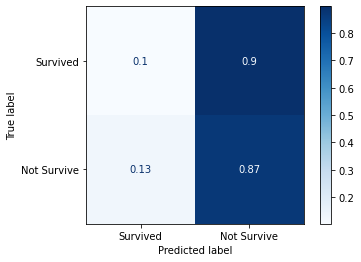

In [183]:

cm = confusion_matrix(y_test, y_pred_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Survived', 'Not Survive'],)
disp.plot(cmap = 'Blues')

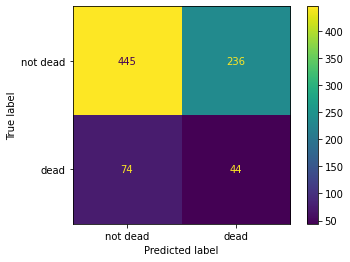

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['not dead', 'dead'])
disp.plot()

In [67]:
# modeling

import keras
from keras import Model
from keras.layers import Input, Dense, Bidirectional, Masking, Embedding, Dropout
from keras.layers import LSTM
import numpy as np

# class weight

class_weight = {0: 1.,
                1: 5.}

# model:2-layer bi-directional LSTM using all time series features and then FCNN for classification
special_value = -1
def define_model():
    input1 = Input(shape=input_shape) 
    mask = Masking(mask_value=special_value)(input1)
    lstm1 = Bidirectional(LSTM(units=16))(mask)
    # lstm2 = Bidirectional(LSTM(units=32))(lstm1)
    # dnn_hidden_layer1 = Dense(64, activation='relu')(lstm2)
    dropout = Dropout(0.2)(lstm1)
    dnn_hidden_layer2 = Dense(16, activation='relu')(dropout)
    dnn_output = Dense(1, activation='sigmoid')(dnn_hidden_layer2)
    model = Model(inputs=[input1],outputs=[dnn_output])
    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',keras.metrics.Recall()])
    model.summary()
    return model


In [70]:
model_1 = define_model()


callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
model_1.fit(X_train,y_train,epochs=50,batch_size=512,verbose=1,class_weight=class_weight,callbacks=callbacks,validation_split=.2)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2881, 22)]        0         
                                                                 
 masking_2 (Masking)         (None, 2881, 22)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               4992      
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                           

In [71]:
# test performance: recall

classifier_thresh = 0.3
y_pred_test = model_1.predict(X_test)
y_pred_test[y_pred_test<classifier_thresh] = 0
y_pred_test[y_pred_test>=classifier_thresh] = 1
recall_test = recall_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
print(recall_test)
print(precision_test)
print(f1_test)

25/25 [==============================] - 33s 1s/step
0.8623853211009175
0.13884785819793205
0.23918575063613232


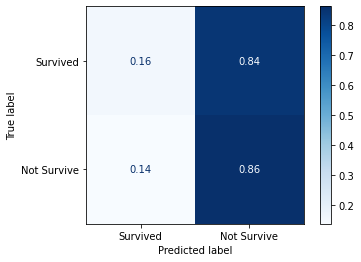

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Survived', 'Not Survive'])
disp.plot(cmap = 'Blues')

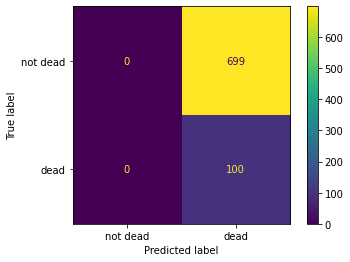

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['not dead', 'dead'])
disp.plot()

100/100 [==============================] - 1s 14ms/step


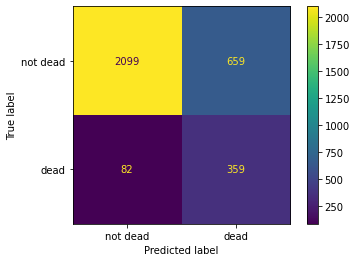

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_train[y_pred_train<classifier_thresh] = 0
y_pred_train[y_pred_train>=classifier_thresh] = 1
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['not dead', 'dead'])
disp.plot()

In [ ]:
recall_train = recall_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)
acc_train = accuracy_score(y_train, y_pred_train)
print(recall_train)
print(precision_train)
print(f1_train)
print(acc_train)

0.8140589569160998
0.3526522593320236
0.4921178889650446
0.7683651140981557
